The following code defines LSTM model setup trained on both data modalities - audio and visual data combined together. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

2022-05-27 23:58:39.749116: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import sys
sys.path.insert(1, '../')

from data_preparation import prepare_x_data, get_Y_labels, reshape_Y, reshape_X, unscale_Y

In [4]:
scaler = StandardScaler()

## Data preparation

Data preparation includes: <br>
<ul>
  <li>selecting necessary features from source files</li>
  <li>creating combined dataset for the model training</li>
  <li>reshaping data for model training.</li>

### X data - audio and visual features

In [5]:
x_train_visual = prepare_x_data('../Data/LLDs_video_openface/train',',', 5, scaler)
x_train_audio = prepare_x_data('../Data/LLDs_audio_eGeMAPS/train',';', 2, scaler) 

In [6]:
x_test_visual = prepare_x_data('../Data/LLDs_video_openface/dev',',', 5, scaler) 
x_test_audio = prepare_x_data('../Data/LLDs_audio_eGeMAPS/dev',';', 2, scaler) 

### Y data - YMRS score

In [7]:
y_train = get_Y_labels('../Data/labels_metadata.csv', 60, 164, scaler)
y_train = reshape_Y(y_train,len(x_train_visual),1,1)

In [8]:
y_test = get_Y_labels('../Data/labels_metadata.csv', 0, 60, scaler)
y_test = reshape_Y(y_test,len(x_test_visual),1,1)

## Model setup - LSTM

Proposed model for LSTM recurrent neural network architecture for multi-modal dataset. Both data modalities are concatenated together before the last Dense layer.

In [9]:
visual_input = keras.Input(shape=(None,465), name="visual")
audio_input = keras.Input(shape=(None,23), name="audio")

In [10]:
visual_features = layers.LSTM(units = 207, input_shape=(None, 465), return_sequences=True)(visual_input)
visual_features = layers.Dropout(0.004)(visual_features)
visual_features = layers.LSTM(units = 207, input_shape=(None, 207), return_sequences=False)(visual_features)
visual_features = layers.Dropout(0.004)(visual_features)

2022-05-27 23:59:29.575811: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-27 23:59:29.586369: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-27 23:59:30.040517: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-27 23:59:30.046308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-05-27 23:59:30.046385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-27 23:59:30.080081: I tensorflow/stream_executor/plat

In [11]:
audio_features = layers.LSTM(units = 12, input_shape=(None,23), return_sequences=True)(audio_input)
audio_features = layers.Dropout(0.004)(audio_features)
audio_features = layers.LSTM(units = 11, input_shape=(None,12), return_sequences=False)(audio_features)
audio_features = layers.Dropout(0.004)(audio_features)

In [12]:
x = layers.concatenate([visual_features, audio_features])

In [13]:
x = layers.Dense(1, activation='linear')(x)

In [14]:
y_pred =layers.Dense(1, name="ymrs")(x)

In [15]:
model = keras.Model(
    inputs=[visual_input, audio_input],
    outputs=[y_pred]
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
visual (InputLayer)             [(None, None, 465)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, None, 23)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 207)    557244      visual[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 12)     1728        audio[0][0]                      
______________________________________________________________________________________________

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.004),
    loss='mse',           
    metrics= [keras.metrics.MeanAbsoluteError()] #['mean_absolute_error']
)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
visual (InputLayer)             [(None, None, 465)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, None, 23)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 207)    557244      visual[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 12)     1728        audio[0][0]                      
______________________________________________________________________________________________

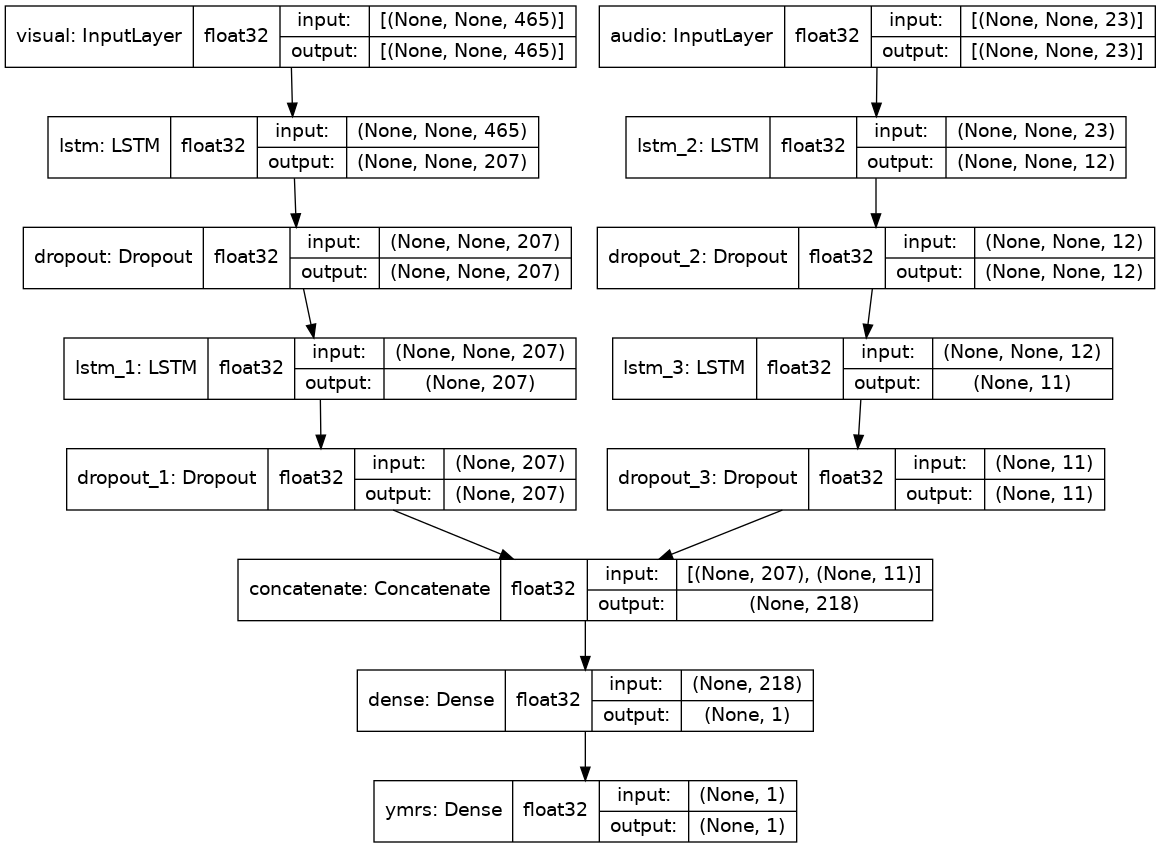

In [19]:
keras.utils.plot_model(model=model, show_dtype=True, show_layer_names=True, show_shapes=True, to_file='LSTM_multimodal.png')

### Model training

Model training setup is based on an iterative approach where model is trained one file at a time, then learned parameters are saved and loaded in the next iterative step. This setup is necessary due to the fact that source files does not have an uniform size and differ in number of frames.

In [20]:
train_index = 0
val_index = 0

loss = {}
train_eval = []
train_loss = []
train_mae = []

for train_visual, train_audio in zip(x_train_visual, x_train_audio):    
        train_visual = np.array(train_visual).reshape((1, train_visual.shape[0], -1))
        train_audio = np.array(train_audio).reshape((1, train_audio.shape[0], -1))
                
        history = model.fit(
            [train_visual, train_audio], 
            y_train[train_index],
            epochs=10,
        )

        loss.update({train_index:history.history})

        train_index += 1

        model.save(r'LSTM_train_multimodal', include_optimizer = True)
        model = keras.models.load_model(r'LSTM_train_multimodal')

        scores = model.evaluate([train_visual, train_audio], y_train[train_index], verbose = 0)
        train_eval.append(scores)
        train_loss.append(scores[0])
        train_mae.append(scores[1])
        
        val_index += 1

2022-05-27 23:59:34.444208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-27 23:59:34.448519: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994375000 Hz


Epoch 1/10


2022-05-27 23:59:42.436910: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-27 23:59:43.056141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1/1 [==============================] - 12s 12s/step - loss: 0.1474 - mean_absolute_error: 0.3839
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 70.1314 - mean_absolute_error: 8.3744
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0895 - mean_absolute_error: 0.2992
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 10.4289 - mean_absolute_error: 3.2294
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 2.3754 - mean_absolute_error: 1.5412
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.1524 - mean_absolute_error: 0.3904
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0897 - mean_absolute_error: 0.2995
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.4220 - mean_absolute_error: 0.6497
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.3998 - mean_absolute_error: 0.6323
Epoch 10/10
1/1 [==============================] - 1s

2022-05-28 00:00:00.460573: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.1754 - mean_absolute_error: 1.0842
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.6213 - mean_absolute_error: 0.7882
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.1104 - mean_absolute_error: 0.3322
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 6.1594e-06 - mean_absolute_error: 0.0025
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0381 - mean_absolute_error: 0.1953
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0507 - mean_absolute_error: 0.2251
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0247 - mean_absolute_error: 0.1571
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - mean_absolute_error: 0.0358
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0077 - mean_absolute_error: 0.0875
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 2.5679 - mean_absolute_error: 1.6025
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 9.4227 - mean_absolute_error: 3.0696
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0712 - mean_absolute_error: 0.2669
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.2968 - mean_absolute_error: 0.5448
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0182 - mean_absolute_error: 0.1350
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0995 - mean_absolute_error: 0.3154
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0207 - mean_absolute_error: 0.1440
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 3.7687e-04 - mean_absolute_error: 0.0194
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0058 - mean_absolute_error: 0.0760
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0010 - mean_absolute_error: 0.0322
Epoch 2/10
1/1 [==============================] - 1s 939ms/step - loss: 13.3513 - mean_absolute_error: 3.6539
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0258 - mean_absolute_error: 0.1606
Epoch 4/10
1/1 [==============================] - 1s 985ms/step - loss: 2.9776 - mean_absolute_error: 1.7256
Epoch 5/10
1/1 [==============================] - 1s 993ms/step - loss: 0.3181 - mean_absolute_error: 0.5640
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.4643 - mean_absolute_error: 0.6814
Epoch 7/10
1/1 [==============================] - 1s 963ms/step - loss: 0.1799 - mean_absolute_error: 0.4241
Epoch 8/10
1/1 [==============================] - 1s 991ms/step - loss: 0.0361 - mean_absolute_error: 0.1900
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0337 - mean_absolute_error: 0.1834
Epoch 10/10
1/1 [=============

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0860 - mean_absolute_error: 0.2932
Epoch 2/10
1/1 [==============================] - 0s 385ms/step - loss: 2.5385 - mean_absolute_error: 1.5933
Epoch 3/10
1/1 [==============================] - 0s 357ms/step - loss: 0.2536 - mean_absolute_error: 0.5036
Epoch 4/10
1/1 [==============================] - 0s 358ms/step - loss: 0.5310 - mean_absolute_error: 0.7287
Epoch 5/10
1/1 [==============================] - 0s 357ms/step - loss: 0.1093 - mean_absolute_error: 0.3305
Epoch 6/10
1/1 [==============================] - 0s 375ms/step - loss: 0.3644 - mean_absolute_error: 0.6036
Epoch 7/10
1/1 [==============================] - 0s 344ms/step - loss: 0.2177 - mean_absolute_error: 0.4666
Epoch 8/10
1/1 [==============================] - 0s 405ms/step - loss: 0.0275 - mean_absolute_error: 0.1657
Epoch 9/10
1/1 [==============================] - 0s 381ms/step - loss: 0.1151 - mean_absolute_error: 0.3393
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1841 - mean_absolute_error: 1.0881
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.1340 - mean_absolute_error: 1.4608
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.5706 - mean_absolute_error: 0.7554
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0686 - mean_absolute_error: 0.2620
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.2311 - mean_absolute_error: 0.4807
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0435 - mean_absolute_error: 0.2085
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0213 - mean_absolute_error: 0.1459
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0166 - mean_absolute_error: 0.1287
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0138 - mean_absolute_error: 0.1174
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.9889 - mean_absolute_error: 1.7288
Epoch 2/10
1/1 [==============================] - 1s 795ms/step - loss: 1.0819 - mean_absolute_error: 1.0401
Epoch 3/10
1/1 [==============================] - 1s 820ms/step - loss: 0.1670 - mean_absolute_error: 0.4087
Epoch 4/10
1/1 [==============================] - 1s 787ms/step - loss: 0.4432 - mean_absolute_error: 0.6658
Epoch 5/10
1/1 [==============================] - 1s 791ms/step - loss: 0.1984 - mean_absolute_error: 0.4455
Epoch 6/10
1/1 [==============================] - 1s 816ms/step - loss: 0.0209 - mean_absolute_error: 0.1445
Epoch 7/10
1/1 [==============================] - 1s 759ms/step - loss: 0.0012 - mean_absolute_error: 0.0348
Epoch 8/10
1/1 [==============================] - 1s 894ms/step - loss: 0.0037 - mean_absolute_error: 0.0610
Epoch 9/10
1/1 [==============================] - 1s 764ms/step - loss: 0.0065 - mean_absolute_error: 0.0808
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.7983 - mean_absolute_error: 0.8935
Epoch 2/10
1/1 [==============================] - 1s 563ms/step - loss: 2.3776 - mean_absolute_error: 1.5419
Epoch 3/10
1/1 [==============================] - 1s 638ms/step - loss: 0.2349 - mean_absolute_error: 0.4847
Epoch 4/10
1/1 [==============================] - 1s 530ms/step - loss: 0.1322 - mean_absolute_error: 0.3635
Epoch 5/10
1/1 [==============================] - 1s 617ms/step - loss: 0.2291 - mean_absolute_error: 0.4787
Epoch 6/10
1/1 [==============================] - 1s 700ms/step - loss: 0.3096 - mean_absolute_error: 0.5564
Epoch 7/10
1/1 [==============================] - 1s 584ms/step - loss: 0.0857 - mean_absolute_error: 0.2928
Epoch 8/10
1/1 [==============================] - 1s 537ms/step - loss: 0.0037 - mean_absolute_error: 0.0609
Epoch 9/10
1/1 [==============================] - 1s 602ms/step - loss: 0.1083 - mean_absolute_error: 0.3291
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 6.8597 - mean_absolute_error: 2.6191
Epoch 2/10
1/1 [==============================] - 1s 548ms/step - loss: 4.2686 - mean_absolute_error: 2.0661
Epoch 3/10
1/1 [==============================] - 1s 543ms/step - loss: 2.4090 - mean_absolute_error: 1.5521
Epoch 4/10
1/1 [==============================] - 1s 598ms/step - loss: 1.1667 - mean_absolute_error: 1.0801
Epoch 5/10
1/1 [==============================] - 1s 663ms/step - loss: 0.3854 - mean_absolute_error: 0.6208
Epoch 6/10
1/1 [==============================] - 1s 547ms/step - loss: 0.0043 - mean_absolute_error: 0.0657
Epoch 7/10
1/1 [==============================] - 1s 540ms/step - loss: 0.3335 - mean_absolute_error: 0.5775
Epoch 8/10
1/1 [==============================] - 1s 590ms/step - loss: 0.3145 - mean_absolute_error: 0.5608
Epoch 9/10
1/1 [==============================] - 1s 549ms/step - loss: 0.1323 - mean_absolute_error: 0.3638
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.3851 - mean_absolute_error: 1.8399
Epoch 2/10
1/1 [==============================] - 1s 666ms/step - loss: 0.3659 - mean_absolute_error: 0.6049
Epoch 3/10
1/1 [==============================] - 1s 589ms/step - loss: 0.0326 - mean_absolute_error: 0.1805
Epoch 4/10
1/1 [==============================] - 1s 517ms/step - loss: 0.0346 - mean_absolute_error: 0.1860
Epoch 5/10
1/1 [==============================] - 1s 609ms/step - loss: 0.0494 - mean_absolute_error: 0.2223
Epoch 6/10
1/1 [==============================] - 1s 634ms/step - loss: 0.0033 - mean_absolute_error: 0.0572
Epoch 7/10
1/1 [==============================] - 1s 525ms/step - loss: 0.0023 - mean_absolute_error: 0.0480
Epoch 8/10
1/1 [==============================] - 1s 590ms/step - loss: 6.6684e-04 - mean_absolute_error: 0.0258
Epoch 9/10
1/1 [==============================] - 1s 679ms/step - loss: 2.8914e-04 - mean_absolute_error: 0.0170
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0457 - mean_absolute_error: 0.2138
Epoch 2/10
1/1 [==============================] - 1s 644ms/step - loss: 0.7550 - mean_absolute_error: 0.8689
Epoch 3/10
1/1 [==============================] - 1s 590ms/step - loss: 0.1005 - mean_absolute_error: 0.3170
Epoch 4/10
1/1 [==============================] - 1s 597ms/step - loss: 0.2625 - mean_absolute_error: 0.5124
Epoch 5/10
1/1 [==============================] - 1s 578ms/step - loss: 0.1078 - mean_absolute_error: 0.3284
Epoch 6/10
1/1 [==============================] - 1s 633ms/step - loss: 0.0017 - mean_absolute_error: 0.0407
Epoch 7/10
1/1 [==============================] - 1s 630ms/step - loss: 0.0441 - mean_absolute_error: 0.2101
Epoch 8/10
1/1 [==============================] - 1s 631ms/step - loss: 0.0607 - mean_absolute_error: 0.2464
Epoch 9/10
1/1 [==============================] - 1s 618ms/step - loss: 0.0242 - mean_absolute_error: 0.1555
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.0368 - mean_absolute_error: 1.4272
Epoch 2/10
1/1 [==============================] - 1s 903ms/step - loss: 0.7242 - mean_absolute_error: 0.8510
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.1052 - mean_absolute_error: 0.3244
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0320 - mean_absolute_error: 0.1790
Epoch 5/10
1/1 [==============================] - 1s 875ms/step - loss: 0.1897 - mean_absolute_error: 0.4355
Epoch 6/10
1/1 [==============================] - 1s 980ms/step - loss: 0.1842 - mean_absolute_error: 0.4292
Epoch 7/10
1/1 [==============================] - 1s 864ms/step - loss: 0.0505 - mean_absolute_error: 0.2247
Epoch 8/10
1/1 [==============================] - 1s 987ms/step - loss: 7.3301e-07 - mean_absolute_error: 8.5616e-04
Epoch 9/10
1/1 [==============================] - 1s 918ms/step - loss: 0.0071 - mean_absolute_error: 0.0844
Epoch 10/10
1/1 [===

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.5467 - mean_absolute_error: 1.2437
Epoch 2/10
1/1 [==============================] - 1s 762ms/step - loss: 0.1038 - mean_absolute_error: 0.3221
Epoch 3/10
1/1 [==============================] - 1s 739ms/step - loss: 0.6414 - mean_absolute_error: 0.8009
Epoch 4/10
1/1 [==============================] - 1s 643ms/step - loss: 0.3004 - mean_absolute_error: 0.5481
Epoch 5/10
1/1 [==============================] - 1s 752ms/step - loss: 0.1056 - mean_absolute_error: 0.3249
Epoch 6/10
1/1 [==============================] - 1s 832ms/step - loss: 0.0095 - mean_absolute_error: 0.0973
Epoch 7/10
1/1 [==============================] - 1s 632ms/step - loss: 0.0329 - mean_absolute_error: 0.1814
Epoch 8/10
1/1 [==============================] - 1s 836ms/step - loss: 0.1364 - mean_absolute_error: 0.3693
Epoch 9/10
1/1 [==============================] - 1s 630ms/step - loss: 0.0723 - mean_absolute_error: 0.2688
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 8.4121 - mean_absolute_error: 2.9004
Epoch 2/10
1/1 [==============================] - 1s 671ms/step - loss: 3.9411 - mean_absolute_error: 1.9852
Epoch 3/10
1/1 [==============================] - 1s 636ms/step - loss: 1.0851 - mean_absolute_error: 1.0417
Epoch 4/10
1/1 [==============================] - 1s 628ms/step - loss: 0.0166 - mean_absolute_error: 0.1290
Epoch 5/10
1/1 [==============================] - 1s 513ms/step - loss: 0.7437 - mean_absolute_error: 0.8624
Epoch 6/10
1/1 [==============================] - 1s 506ms/step - loss: 1.0041 - mean_absolute_error: 1.0020
Epoch 7/10
1/1 [==============================] - 1s 626ms/step - loss: 0.9713 - mean_absolute_error: 0.9856
Epoch 8/10
1/1 [==============================] - 1s 532ms/step - loss: 0.5094 - mean_absolute_error: 0.7137
Epoch 9/10
1/1 [==============================] - 1s 581ms/step - loss: 0.1881 - mean_absolute_error: 0.4337
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6312 - mean_absolute_error: 0.7945
Epoch 2/10
1/1 [==============================] - 0s 191ms/step - loss: 5.6869e-04 - mean_absolute_error: 0.0238
Epoch 3/10
1/1 [==============================] - 0s 218ms/step - loss: 0.0773 - mean_absolute_error: 0.2780
Epoch 4/10
1/1 [==============================] - 0s 216ms/step - loss: 0.0404 - mean_absolute_error: 0.2009
Epoch 5/10
1/1 [==============================] - 0s 201ms/step - loss: 0.0183 - mean_absolute_error: 0.1353
Epoch 6/10
1/1 [==============================] - 0s 211ms/step - loss: 1.7380e-05 - mean_absolute_error: 0.0042
Epoch 7/10
1/1 [==============================] - 0s 179ms/step - loss: 2.6138e-04 - mean_absolute_error: 0.0162
Epoch 8/10
1/1 [==============================] - 0s 259ms/step - loss: 0.0014 - mean_absolute_error: 0.0381
Epoch 9/10
1/1 [==============================] - 0s 208ms/step - loss: 2.8034e-04 - mean_absolute_error: 0.0167
Epoch 

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.5878 - mean_absolute_error: 1.6087
Epoch 2/10
1/1 [==============================] - 1s 552ms/step - loss: 0.5143 - mean_absolute_error: 0.7171
Epoch 3/10
1/1 [==============================] - 1s 550ms/step - loss: 0.0066 - mean_absolute_error: 0.0811
Epoch 4/10
1/1 [==============================] - 1s 634ms/step - loss: 0.2078 - mean_absolute_error: 0.4559
Epoch 5/10
1/1 [==============================] - 1s 558ms/step - loss: 0.3420 - mean_absolute_error: 0.5848
Epoch 6/10
1/1 [==============================] - 1s 518ms/step - loss: 0.1401 - mean_absolute_error: 0.3742
Epoch 7/10
1/1 [==============================] - 1s 553ms/step - loss: 0.0091 - mean_absolute_error: 0.0951
Epoch 8/10
1/1 [==============================] - 1s 521ms/step - loss: 0.0055 - mean_absolute_error: 0.0744
Epoch 9/10
1/1 [==============================] - 1s 526ms/step - loss: 0.0167 - mean_absolute_error: 0.1293
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 4.5646 - mean_absolute_error: 2.1365
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 3.7032 - mean_absolute_error: 1.9244
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 2.3924 - mean_absolute_error: 1.5467
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 1.4528 - mean_absolute_error: 1.2053
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.5920 - mean_absolute_error: 0.7694
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.0662 - mean_absolute_error: 0.2573
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.1174 - mean_absolute_error: 0.3426
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.3232 - mean_absolute_error: 0.5685
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.2390 - mean_absolute_error: 0.4888
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 5.5608 - mean_absolute_error: 2.3581
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.6408 - mean_absolute_error: 1.6251
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.8452 - mean_absolute_error: 0.9193
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.1590 - mean_absolute_error: 0.3987
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - mean_absolute_error: 0.0332
Epoch 6/10
1/1 [==============================] - 1s 862ms/step - loss: 0.0796 - mean_absolute_error: 0.2822
Epoch 7/10
1/1 [==============================] - 1s 920ms/step - loss: 0.1021 - mean_absolute_error: 0.3195
Epoch 8/10
1/1 [==============================] - 1s 969ms/step - loss: 0.0798 - mean_absolute_error: 0.2824
Epoch 9/10
1/1 [==============================] - 1s 877ms/step - loss: 0.0426 - mean_absolute_error: 0.2063
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1377 - mean_absolute_error: 0.3711
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.7778 - mean_absolute_error: 0.8819
Epoch 3/10
1/1 [==============================] - 1s 988ms/step - loss: 0.0948 - mean_absolute_error: 0.3079
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0217 - mean_absolute_error: 0.1472
Epoch 5/10
1/1 [==============================] - 1s 983ms/step - loss: 0.0340 - mean_absolute_error: 0.1844
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 8.0528e-04 - mean_absolute_error: 0.0284
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0045 - mean_absolute_error: 0.0671
Epoch 8/10
1/1 [==============================] - 1s 993ms/step - loss: 0.0053 - mean_absolute_error: 0.0727
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0620
Epoch 10/10
1/1 [================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.8065 - mean_absolute_error: 0.8981
Epoch 2/10
1/1 [==============================] - 0s 433ms/step - loss: 0.0347 - mean_absolute_error: 0.1862
Epoch 3/10
1/1 [==============================] - 0s 407ms/step - loss: 0.2067 - mean_absolute_error: 0.4546
Epoch 4/10
1/1 [==============================] - 0s 412ms/step - loss: 0.0104 - mean_absolute_error: 0.1018
Epoch 5/10
1/1 [==============================] - 0s 426ms/step - loss: 7.4478e-04 - mean_absolute_error: 0.0273
Epoch 6/10
1/1 [==============================] - 0s 375ms/step - loss: 0.0029 - mean_absolute_error: 0.0542
Epoch 7/10
1/1 [==============================] - 0s 392ms/step - loss: 0.0122 - mean_absolute_error: 0.1104
Epoch 8/10
1/1 [==============================] - 0s 385ms/step - loss: 0.0031 - mean_absolute_error: 0.0557
Epoch 9/10
1/1 [==============================] - 0s 369ms/step - loss: 1.7554e-04 - mean_absolute_error: 0.0132
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.1989 - mean_absolute_error: 0.4460
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0013 - mean_absolute_error: 0.0357
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0635 - mean_absolute_error: 0.2521
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0298 - mean_absolute_error: 0.1726
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 6.5803e-04 - mean_absolute_error: 0.0257
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0161 - mean_absolute_error: 0.1270
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0195 - mean_absolute_error: 0.1395
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0748
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0034 - mean_absolute_error: 0.0582
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.2649e-05 - mean_absolute_error: 0.0036
Epoch 2/10
1/1 [==============================] - 1s 689ms/step - loss: 0.1963 - mean_absolute_error: 0.4431
Epoch 3/10
1/1 [==============================] - 1s 578ms/step - loss: 0.0025 - mean_absolute_error: 0.0495
Epoch 4/10
1/1 [==============================] - 1s 754ms/step - loss: 0.0133 - mean_absolute_error: 0.1155
Epoch 5/10
1/1 [==============================] - 1s 680ms/step - loss: 0.0776 - mean_absolute_error: 0.2785
Epoch 6/10
1/1 [==============================] - 1s 672ms/step - loss: 0.0263 - mean_absolute_error: 0.1622
Epoch 7/10
1/1 [==============================] - 1s 747ms/step - loss: 0.0071 - mean_absolute_error: 0.0841
Epoch 8/10
1/1 [==============================] - 1s 591ms/step - loss: 0.0099 - mean_absolute_error: 0.0996
Epoch 9/10
1/1 [==============================] - 1s 674ms/step - loss: 0.0067 - mean_absolute_error: 0.0818
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.5142 - mean_absolute_error: 1.8746
Epoch 2/10
1/1 [==============================] - 1s 781ms/step - loss: 2.5849 - mean_absolute_error: 1.6077
Epoch 3/10
1/1 [==============================] - 1s 861ms/step - loss: 1.9081 - mean_absolute_error: 1.3814
Epoch 4/10
1/1 [==============================] - 1s 745ms/step - loss: 1.2421 - mean_absolute_error: 1.1145
Epoch 5/10
1/1 [==============================] - 1s 663ms/step - loss: 0.6249 - mean_absolute_error: 0.7905
Epoch 6/10
1/1 [==============================] - 1s 669ms/step - loss: 0.0948 - mean_absolute_error: 0.3079
Epoch 7/10
1/1 [==============================] - 1s 709ms/step - loss: 0.0354 - mean_absolute_error: 0.1880
Epoch 8/10
1/1 [==============================] - 1s 705ms/step - loss: 0.2439 - mean_absolute_error: 0.4938
Epoch 9/10
1/1 [==============================] - 1s 674ms/step - loss: 0.2317 - mean_absolute_error: 0.4814
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0012 - mean_absolute_error: 0.0343
Epoch 2/10
1/1 [==============================] - 1s 541ms/step - loss: 0.3826 - mean_absolute_error: 0.6186
Epoch 3/10
1/1 [==============================] - 1s 563ms/step - loss: 0.0301 - mean_absolute_error: 0.1736
Epoch 4/10
1/1 [==============================] - 1s 626ms/step - loss: 0.1546 - mean_absolute_error: 0.3932
Epoch 5/10
1/1 [==============================] - 1s 535ms/step - loss: 0.0779 - mean_absolute_error: 0.2791
Epoch 6/10
1/1 [==============================] - 1s 601ms/step - loss: 0.0891 - mean_absolute_error: 0.2985
Epoch 7/10
1/1 [==============================] - 1s 579ms/step - loss: 0.0206 - mean_absolute_error: 0.1434
Epoch 8/10
1/1 [==============================] - 1s 559ms/step - loss: 6.9313e-04 - mean_absolute_error: 0.0263
Epoch 9/10
1/1 [==============================] - 1s 529ms/step - loss: 0.0062 - mean_absolute_error: 0.0788
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.8715 - mean_absolute_error: 1.3680
Epoch 2/10
1/1 [==============================] - 1s 988ms/step - loss: 0.6257 - mean_absolute_error: 0.7910
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0969 - mean_absolute_error: 0.3113
Epoch 4/10
1/1 [==============================] - 1s 992ms/step - loss: 0.0096 - mean_absolute_error: 0.0979
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0406 - mean_absolute_error: 0.2016
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0546 - mean_absolute_error: 0.2338
Epoch 7/10
1/1 [==============================] - 1s 997ms/step - loss: 0.0405 - mean_absolute_error: 0.2013
Epoch 8/10
1/1 [==============================] - 1s 991ms/step - loss: 0.0243 - mean_absolute_error: 0.1560
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0115 - mean_absolute_error: 0.1073
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0624 - mean_absolute_error: 0.2498
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0276 - mean_absolute_error: 0.1662
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0548 - mean_absolute_error: 0.2341
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0079 - mean_absolute_error: 0.0888
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0039 - mean_absolute_error: 0.0624
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0095 - mean_absolute_error: 0.0975
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0138 - mean_absolute_error: 0.1173
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0084 - mean_absolute_error: 0.0914
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 7.0661e-04 - mean_absolute_error: 0.0266
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1715 - mean_absolute_error: 1.0824
Epoch 2/10
1/1 [==============================] - 1s 919ms/step - loss: 0.1132 - mean_absolute_error: 0.3364
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0335 - mean_absolute_error: 0.1832
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.1329 - mean_absolute_error: 0.3646
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0797 - mean_absolute_error: 0.2822
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0680 - mean_absolute_error: 0.2608
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0229 - mean_absolute_error: 0.1512
Epoch 8/10
1/1 [==============================] - 1s 918ms/step - loss: 5.1208e-04 - mean_absolute_error: 0.0226
Epoch 9/10
1/1 [==============================] - 1s 896ms/step - loss: 0.0048 - mean_absolute_error: 0.0694
Epoch 10/10
1/1 [================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1061 - mean_absolute_error: 0.3257
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0093 - mean_absolute_error: 0.0965
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0379 - mean_absolute_error: 0.1946
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0263 - mean_absolute_error: 0.1622
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0615
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0559
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0143 - mean_absolute_error: 0.1195
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - mean_absolute_error: 0.0329
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0071 - mean_absolute_error: 0.0842
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0030 - mean_absolute_error: 0.0547
Epoch 2/10
1/1 [==============================] - 0s 470ms/step - loss: 0.0870 - mean_absolute_error: 0.2949
Epoch 3/10
1/1 [==============================] - 0s 447ms/step - loss: 0.0056 - mean_absolute_error: 0.0746
Epoch 4/10
1/1 [==============================] - 0s 458ms/step - loss: 0.0137 - mean_absolute_error: 0.1169
Epoch 5/10
1/1 [==============================] - 0s 457ms/step - loss: 0.0588 - mean_absolute_error: 0.2426
Epoch 6/10
1/1 [==============================] - 0s 470ms/step - loss: 0.0206 - mean_absolute_error: 0.1434
Epoch 7/10
1/1 [==============================] - 1s 544ms/step - loss: 0.0032 - mean_absolute_error: 0.0570
Epoch 8/10
1/1 [==============================] - 1s 526ms/step - loss: 0.0022 - mean_absolute_error: 0.0474
Epoch 9/10
1/1 [==============================] - 0s 468ms/step - loss: 0.0072 - mean_absolute_error: 0.0847
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.1217 - mean_absolute_error: 1.0591
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4705 - mean_absolute_error: 0.6860
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.1186 - mean_absolute_error: 0.3443
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 2.1862e-04 - mean_absolute_error: 0.0148
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0833 - mean_absolute_error: 0.2886
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.1416 - mean_absolute_error: 0.3763
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0647 - mean_absolute_error: 0.2544
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0463 - mean_absolute_error: 0.2151
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0215 - mean_absolute_error: 0.1467
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.9106 - mean_absolute_error: 1.3822
Epoch 2/10
1/1 [==============================] - 1s 770ms/step - loss: 1.1274 - mean_absolute_error: 1.0618
Epoch 3/10
1/1 [==============================] - 1s 911ms/step - loss: 0.5890 - mean_absolute_error: 0.7674
Epoch 4/10
1/1 [==============================] - 1s 746ms/step - loss: 0.2484 - mean_absolute_error: 0.4984
Epoch 5/10
1/1 [==============================] - 1s 733ms/step - loss: 0.0575 - mean_absolute_error: 0.2398
Epoch 6/10
1/1 [==============================] - 1s 742ms/step - loss: 2.8299e-05 - mean_absolute_error: 0.0053
Epoch 7/10
1/1 [==============================] - 1s 729ms/step - loss: 0.0392 - mean_absolute_error: 0.1980
Epoch 8/10
1/1 [==============================] - 1s 862ms/step - loss: 0.0890 - mean_absolute_error: 0.2984
Epoch 9/10
1/1 [==============================] - 1s 915ms/step - loss: 0.1295 - mean_absolute_error: 0.3599
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.3947 - mean_absolute_error: 1.1810
Epoch 2/10
1/1 [==============================] - 1s 515ms/step - loss: 0.7118 - mean_absolute_error: 0.8437
Epoch 3/10
1/1 [==============================] - 1s 559ms/step - loss: 0.2897 - mean_absolute_error: 0.5382
Epoch 4/10
1/1 [==============================] - 0s 447ms/step - loss: 0.0497 - mean_absolute_error: 0.2229
Epoch 5/10
1/1 [==============================] - 1s 573ms/step - loss: 0.0108 - mean_absolute_error: 0.1038
Epoch 6/10
1/1 [==============================] - 0s 437ms/step - loss: 0.0882 - mean_absolute_error: 0.2970
Epoch 7/10
1/1 [==============================] - 1s 510ms/step - loss: 0.1157 - mean_absolute_error: 0.3401
Epoch 8/10
1/1 [==============================] - 0s 475ms/step - loss: 0.1044 - mean_absolute_error: 0.3232
Epoch 9/10
1/1 [==============================] - 0s 438ms/step - loss: 0.0789 - mean_absolute_error: 0.2810
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1309 - mean_absolute_error: 0.3619
Epoch 2/10
1/1 [==============================] - 1s 764ms/step - loss: 1.9118e-05 - mean_absolute_error: 0.0044
Epoch 3/10
1/1 [==============================] - 1s 661ms/step - loss: 0.0272 - mean_absolute_error: 0.1649
Epoch 4/10
1/1 [==============================] - 1s 808ms/step - loss: 0.0182 - mean_absolute_error: 0.1348
Epoch 5/10
1/1 [==============================] - 1s 697ms/step - loss: 0.0097 - mean_absolute_error: 0.0984
Epoch 6/10
1/1 [==============================] - 1s 693ms/step - loss: 0.0015 - mean_absolute_error: 0.0391
Epoch 7/10
1/1 [==============================] - 1s 694ms/step - loss: 9.0429e-04 - mean_absolute_error: 0.0301
Epoch 8/10
1/1 [==============================] - 1s 714ms/step - loss: 0.0034 - mean_absolute_error: 0.0582
Epoch 9/10
1/1 [==============================] - 1s 884ms/step - loss: 0.0066 - mean_absolute_error: 0.0812
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3119 - mean_absolute_error: 0.5585
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.2296 - mean_absolute_error: 0.4792
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0281 - mean_absolute_error: 0.1675
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - mean_absolute_error: 0.0445
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0225 - mean_absolute_error: 0.1500
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0335 - mean_absolute_error: 0.1831
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0326 - mean_absolute_error: 0.1807
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0250 - mean_absolute_error: 0.1580
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0164 - mean_absolute_error: 0.1281
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.1138 - mean_absolute_error: 0.3373
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0119 - mean_absolute_error: 0.1091
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0681
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236 - mean_absolute_error: 0.1538
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0232 - mean_absolute_error: 0.1522
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0150 - mean_absolute_error: 0.1226
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0755
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 8.6671e-04 - mean_absolute_error: 0.0294
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 1.4562e-04 - mean_absolute_error: 0.0121
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0355 - mean_absolute_error: 0.1885
Epoch 2/10
1/1 [==============================] - 0s 496ms/step - loss: 0.0766 - mean_absolute_error: 0.2767
Epoch 3/10
1/1 [==============================] - 1s 568ms/step - loss: 0.0307 - mean_absolute_error: 0.1752
Epoch 4/10
1/1 [==============================] - 1s 597ms/step - loss: 0.0024 - mean_absolute_error: 0.0485
Epoch 5/10
1/1 [==============================] - 0s 473ms/step - loss: 0.0047 - mean_absolute_error: 0.0684
Epoch 6/10
1/1 [==============================] - 1s 517ms/step - loss: 0.0101 - mean_absolute_error: 0.1005
Epoch 7/10
1/1 [==============================] - 1s 572ms/step - loss: 0.0101 - mean_absolute_error: 0.1007
Epoch 8/10
1/1 [==============================] - 0s 458ms/step - loss: 0.0054 - mean_absolute_error: 0.0735
Epoch 9/10
1/1 [==============================] - 1s 503ms/step - loss: 0.0026 - mean_absolute_error: 0.0510
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.7272 - mean_absolute_error: 0.8528
Epoch 2/10
1/1 [==============================] - 1s 803ms/step - loss: 0.3289 - mean_absolute_error: 0.5735
Epoch 3/10
1/1 [==============================] - 1s 807ms/step - loss: 0.0963 - mean_absolute_error: 0.3103
Epoch 4/10
1/1 [==============================] - 1s 932ms/step - loss: 9.7775e-04 - mean_absolute_error: 0.0313
Epoch 5/10
1/1 [==============================] - 1s 950ms/step - loss: 0.0291 - mean_absolute_error: 0.1705
Epoch 6/10
1/1 [==============================] - 1s 850ms/step - loss: 0.0661 - mean_absolute_error: 0.2572
Epoch 7/10
1/1 [==============================] - 1s 841ms/step - loss: 0.0902 - mean_absolute_error: 0.3003
Epoch 8/10
1/1 [==============================] - 1s 821ms/step - loss: 0.0694 - mean_absolute_error: 0.2635
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0473 - mean_absolute_error: 0.2174
Epoch 10/10
1/1 [====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.0160 - mean_absolute_error: 1.7367
Epoch 2/10
1/1 [==============================] - 1s 938ms/step - loss: 1.7903 - mean_absolute_error: 1.3380
Epoch 3/10
1/1 [==============================] - 1s 954ms/step - loss: 1.3743 - mean_absolute_error: 1.1723
Epoch 4/10
1/1 [==============================] - 1s 994ms/step - loss: 0.9461 - mean_absolute_error: 0.9727
Epoch 5/10
1/1 [==============================] - 1s 923ms/step - loss: 0.5599 - mean_absolute_error: 0.7482
Epoch 6/10
1/1 [==============================] - 1s 944ms/step - loss: 0.3124 - mean_absolute_error: 0.5590
Epoch 7/10
1/1 [==============================] - 1s 916ms/step - loss: 0.0461 - mean_absolute_error: 0.2146
Epoch 8/10
1/1 [==============================] - 1s 951ms/step - loss: 0.0471 - mean_absolute_error: 0.2170
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0674 - mean_absolute_error: 0.2596
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.9693 - mean_absolute_error: 1.4033
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.3481 - mean_absolute_error: 1.1611
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.1231 - mean_absolute_error: 1.0598
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.7406 - mean_absolute_error: 0.8606
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.4210 - mean_absolute_error: 0.6489
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.1803 - mean_absolute_error: 0.4246
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0254 - mean_absolute_error: 0.1595
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0194 - mean_absolute_error: 0.1391
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.1148 - mean_absolute_error: 0.3388
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.3270 - mean_absolute_error: 1.1520
Epoch 2/10
1/1 [==============================] - 1s 764ms/step - loss: 0.7038 - mean_absolute_error: 0.8389
Epoch 3/10
1/1 [==============================] - 1s 795ms/step - loss: 0.3255 - mean_absolute_error: 0.5705
Epoch 4/10
1/1 [==============================] - 1s 786ms/step - loss: 0.0638 - mean_absolute_error: 0.2526
Epoch 5/10
1/1 [==============================] - 1s 870ms/step - loss: 1.1009e-05 - mean_absolute_error: 0.0033
Epoch 6/10
1/1 [==============================] - 1s 832ms/step - loss: 0.0568 - mean_absolute_error: 0.2384
Epoch 7/10
1/1 [==============================] - 1s 762ms/step - loss: 0.0866 - mean_absolute_error: 0.2942
Epoch 8/10
1/1 [==============================] - 1s 800ms/step - loss: 0.0809 - mean_absolute_error: 0.2844
Epoch 9/10
1/1 [==============================] - 1s 763ms/step - loss: 0.0631 - mean_absolute_error: 0.2512
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 4.7501 - mean_absolute_error: 2.1795
Epoch 2/10
1/1 [==============================] - 1s 709ms/step - loss: 3.7250 - mean_absolute_error: 1.9300
Epoch 3/10
1/1 [==============================] - 1s 626ms/step - loss: 3.0056 - mean_absolute_error: 1.7337
Epoch 4/10
1/1 [==============================] - 1s 681ms/step - loss: 2.4260 - mean_absolute_error: 1.5576
Epoch 5/10
1/1 [==============================] - 1s 633ms/step - loss: 1.8865 - mean_absolute_error: 1.3735
Epoch 6/10
1/1 [==============================] - 1s 625ms/step - loss: 1.3681 - mean_absolute_error: 1.1697
Epoch 7/10
1/1 [==============================] - 1s 693ms/step - loss: 0.9448 - mean_absolute_error: 0.9720
Epoch 8/10
1/1 [==============================] - 1s 711ms/step - loss: 0.5440 - mean_absolute_error: 0.7375
Epoch 9/10
1/1 [==============================] - 1s 639ms/step - loss: 0.1776 - mean_absolute_error: 0.4215
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.5275 - mean_absolute_error: 1.2359
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.2647 - mean_absolute_error: 1.1246
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.5905 - mean_absolute_error: 0.7685
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.2791 - mean_absolute_error: 0.5283
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0508 - mean_absolute_error: 0.2254
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0015 - mean_absolute_error: 0.0391
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.1615 - mean_absolute_error: 0.4019
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.1450 - mean_absolute_error: 0.3807
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.1180 - mean_absolute_error: 0.3436
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.5876 - mean_absolute_error: 0.7666
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.7571 - mean_absolute_error: 0.8701
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0599 - mean_absolute_error: 0.2448
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0254 - mean_absolute_error: 0.1595
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.1187 - mean_absolute_error: 0.3446
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0876 - mean_absolute_error: 0.2959
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0441 - mean_absolute_error: 0.2099
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0120 - mean_absolute_error: 0.1097
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 7.4797e-04 - mean_absolute_error: 0.0273
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 11.3595 - mean_absolute_error: 3.3704
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 8.6913 - mean_absolute_error: 2.9481
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 6.6904 - mean_absolute_error: 2.5866
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 5.1584 - mean_absolute_error: 2.2712
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 4.1222 - mean_absolute_error: 2.0303
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 3.2428 - mean_absolute_error: 1.8008
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 2.5230 - mean_absolute_error: 1.5884
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 1.8666 - mean_absolute_error: 1.3662
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 1.2909 - mean_absolute_error: 1.1362
Epoch 10/10
1/1 [============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.2260 - mean_absolute_error: 1.7961
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.7276 - mean_absolute_error: 1.3144
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.8921 - mean_absolute_error: 0.9445
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.4203 - mean_absolute_error: 0.6483
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.1547 - mean_absolute_error: 0.3934
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0266 - mean_absolute_error: 0.1630
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0185 - mean_absolute_error: 0.1359
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0833 - mean_absolute_error: 0.2887
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0873 - mean_absolute_error: 0.2955
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.2475 - mean_absolute_error: 1.4992
Epoch 2/10
1/1 [==============================] - 0s 382ms/step - loss: 1.2065 - mean_absolute_error: 1.0984
Epoch 3/10
1/1 [==============================] - 0s 352ms/step - loss: 0.5862 - mean_absolute_error: 0.7656
Epoch 4/10
1/1 [==============================] - 0s 383ms/step - loss: 0.1462 - mean_absolute_error: 0.3823
Epoch 5/10
1/1 [==============================] - 0s 374ms/step - loss: 0.0099 - mean_absolute_error: 0.0994
Epoch 6/10
1/1 [==============================] - 0s 328ms/step - loss: 0.1455 - mean_absolute_error: 0.3814
Epoch 7/10
1/1 [==============================] - 0s 318ms/step - loss: 0.1436 - mean_absolute_error: 0.3789
Epoch 8/10
1/1 [==============================] - 0s 390ms/step - loss: 0.0807 - mean_absolute_error: 0.2840
Epoch 9/10
1/1 [==============================] - 0s 345ms/step - loss: 0.0442 - mean_absolute_error: 0.2103
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.2346 - mean_absolute_error: 1.7985
Epoch 2/10
1/1 [==============================] - 0s 387ms/step - loss: 1.7037 - mean_absolute_error: 1.3053
Epoch 3/10
1/1 [==============================] - 0s 372ms/step - loss: 0.9203 - mean_absolute_error: 0.9593
Epoch 4/10
1/1 [==============================] - 0s 378ms/step - loss: 0.6162 - mean_absolute_error: 0.7850
Epoch 5/10
1/1 [==============================] - 0s 430ms/step - loss: 0.3773 - mean_absolute_error: 0.6142
Epoch 6/10
1/1 [==============================] - 0s 487ms/step - loss: 0.1799 - mean_absolute_error: 0.4242
Epoch 7/10
1/1 [==============================] - 0s 447ms/step - loss: 0.0577 - mean_absolute_error: 0.2403
Epoch 8/10
1/1 [==============================] - 0s 376ms/step - loss: 6.9358e-04 - mean_absolute_error: 0.0263
Epoch 9/10
1/1 [==============================] - 0s 442ms/step - loss: 0.0417 - mean_absolute_error: 0.2042
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0165 - mean_absolute_error: 0.1284
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0357 - mean_absolute_error: 0.1890
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0655
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 5.0033e-05 - mean_absolute_error: 0.0071
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0022 - mean_absolute_error: 0.0471
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0010 - mean_absolute_error: 0.0318
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0712
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 6.1709e-06 - mean_absolute_error: 0.0025
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0015 - mean_absolute_error: 0.0391
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.1578 - mean_absolute_error: 0.3972
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.0083 - mean_absolute_error: 0.0913
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.0183 - mean_absolute_error: 0.1354
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.0402 - mean_absolute_error: 0.2006
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.0344 - mean_absolute_error: 0.1854
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.0197 - mean_absolute_error: 0.1403
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.0052 - mean_absolute_error: 0.0721
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 1.1801e-04 - mean_absolute_error: 0.0109
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.0013 - mean_absolute_error: 0.0361
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0028 - mean_absolute_error: 0.0529
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0092 - mean_absolute_error: 0.0958
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0014 - mean_absolute_error: 0.0371
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0012 - mean_absolute_error: 0.0342
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - mean_absolute_error: 0.0567
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0024 - mean_absolute_error: 0.0492
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 7.1902e-06 - mean_absolute_error: 0.0027
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 5.1354e-04 - mean_absolute_error: 0.0227
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 4.8658e-05 - mean_absolute_error: 0.0070
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.7558 - mean_absolute_error: 1.3251
Epoch 2/10
1/1 [==============================] - 1s 546ms/step - loss: 1.3628 - mean_absolute_error: 1.1674
Epoch 3/10
1/1 [==============================] - 0s 494ms/step - loss: 1.0399 - mean_absolute_error: 1.0198
Epoch 4/10
1/1 [==============================] - 0s 415ms/step - loss: 0.8337 - mean_absolute_error: 0.9131
Epoch 5/10
1/1 [==============================] - 0s 434ms/step - loss: 0.6438 - mean_absolute_error: 0.8024
Epoch 6/10
1/1 [==============================] - 0s 495ms/step - loss: 0.4695 - mean_absolute_error: 0.6852
Epoch 7/10
1/1 [==============================] - 0s 417ms/step - loss: 0.3331 - mean_absolute_error: 0.5772
Epoch 8/10
1/1 [==============================] - 0s 456ms/step - loss: 0.1661 - mean_absolute_error: 0.4075
Epoch 9/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0580 - mean_absolute_error: 0.2408
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.1741 - mean_absolute_error: 0.4173
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 2.3074e-05 - mean_absolute_error: 0.0048
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0909 - mean_absolute_error: 0.3015
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0175 - mean_absolute_error: 0.1324
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 9.5585e-04 - mean_absolute_error: 0.0309
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.0068 - mean_absolute_error: 0.0824
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.0115 - mean_absolute_error: 0.1074
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0082 - mean_absolute_error: 0.0908
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.0026 - mean_absolute_error: 0.0508
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.3605 - mean_absolute_error: 0.6004
Epoch 2/10
1/1 [==============================] - 1s 553ms/step - loss: 0.0899 - mean_absolute_error: 0.2998
Epoch 3/10
1/1 [==============================] - 0s 486ms/step - loss: 0.0099 - mean_absolute_error: 0.0996
Epoch 4/10
1/1 [==============================] - 1s 539ms/step - loss: 0.0040 - mean_absolute_error: 0.0634
Epoch 5/10
1/1 [==============================] - 0s 432ms/step - loss: 0.0195 - mean_absolute_error: 0.1395
Epoch 6/10
1/1 [==============================] - 0s 446ms/step - loss: 0.0274 - mean_absolute_error: 0.1654
Epoch 7/10
1/1 [==============================] - 0s 474ms/step - loss: 0.0225 - mean_absolute_error: 0.1500
Epoch 8/10
1/1 [==============================] - 1s 561ms/step - loss: 0.0165 - mean_absolute_error: 0.1283
Epoch 9/10
1/1 [==============================] - 1s 563ms/step - loss: 1.8306e-04 - mean_absolute_error: 0.0135
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3568 - mean_absolute_error: 0.5973
Epoch 2/10
1/1 [==============================] - 1s 512ms/step - loss: 0.0994 - mean_absolute_error: 0.3154
Epoch 3/10
1/1 [==============================] - 1s 539ms/step - loss: 0.0243 - mean_absolute_error: 0.1557
Epoch 4/10
1/1 [==============================] - 1s 551ms/step - loss: 1.1399e-04 - mean_absolute_error: 0.0107
Epoch 5/10
1/1 [==============================] - 1s 624ms/step - loss: 0.0079 - mean_absolute_error: 0.0889
Epoch 6/10
1/1 [==============================] - 1s 502ms/step - loss: 0.0279 - mean_absolute_error: 0.1669
Epoch 7/10
1/1 [==============================] - 1s 583ms/step - loss: 0.0269 - mean_absolute_error: 0.1641
Epoch 8/10
1/1 [==============================] - 1s 547ms/step - loss: 0.0165 - mean_absolute_error: 0.1285
Epoch 9/10
1/1 [==============================] - 1s 570ms/step - loss: 0.0065 - mean_absolute_error: 0.0804
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.6752 - mean_absolute_error: 1.2943
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.1619 - mean_absolute_error: 1.0779
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.8036 - mean_absolute_error: 0.8964
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.5697 - mean_absolute_error: 0.7548
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.2990 - mean_absolute_error: 0.5468
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.1256 - mean_absolute_error: 0.3544
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0300 - mean_absolute_error: 0.1731
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 9.0643e-05 - mean_absolute_error: 0.0095
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0343 - mean_absolute_error: 0.1851
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6065 - mean_absolute_error: 0.7788
Epoch 2/10
1/1 [==============================] - 1s 800ms/step - loss: 0.2549 - mean_absolute_error: 0.5049
Epoch 3/10
1/1 [==============================] - 1s 882ms/step - loss: 0.0181 - mean_absolute_error: 0.1344
Epoch 4/10
1/1 [==============================] - 1s 774ms/step - loss: 0.1692 - mean_absolute_error: 0.4113
Epoch 5/10
1/1 [==============================] - 1s 879ms/step - loss: 0.0352 - mean_absolute_error: 0.1877
Epoch 6/10
1/1 [==============================] - 1s 810ms/step - loss: 0.0151 - mean_absolute_error: 0.1229
Epoch 7/10
1/1 [==============================] - 1s 818ms/step - loss: 6.7757e-04 - mean_absolute_error: 0.0260
Epoch 8/10
1/1 [==============================] - 1s 803ms/step - loss: 6.2383e-04 - mean_absolute_error: 0.0250
Epoch 9/10
1/1 [==============================] - 1s 907ms/step - loss: 0.0059 - mean_absolute_error: 0.0767
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0969 - mean_absolute_error: 0.3113
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0021 - mean_absolute_error: 0.0460
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0221 - mean_absolute_error: 0.1487
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0307 - mean_absolute_error: 0.1751
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0239 - mean_absolute_error: 0.1545
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0134 - mean_absolute_error: 0.1157
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0652
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 3.1270e-04 - mean_absolute_error: 0.0177
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 6.0501e-04 - mean_absolute_error: 0.0246
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1567 - mean_absolute_error: 0.3959
Epoch 2/10
1/1 [==============================] - 0s 484ms/step - loss: 0.0186 - mean_absolute_error: 0.1362
Epoch 3/10
1/1 [==============================] - 1s 571ms/step - loss: 0.0108 - mean_absolute_error: 0.1041
Epoch 4/10
1/1 [==============================] - 1s 604ms/step - loss: 0.0169 - mean_absolute_error: 0.1300
Epoch 5/10
1/1 [==============================] - 1s 640ms/step - loss: 0.0179 - mean_absolute_error: 0.1337
Epoch 6/10
1/1 [==============================] - 0s 489ms/step - loss: 0.0065 - mean_absolute_error: 0.0808
Epoch 7/10
1/1 [==============================] - 1s 515ms/step - loss: 0.0061 - mean_absolute_error: 0.0781
Epoch 8/10
1/1 [==============================] - 0s 484ms/step - loss: 0.0033 - mean_absolute_error: 0.0576
Epoch 9/10
1/1 [==============================] - 0s 484ms/step - loss: 0.0011 - mean_absolute_error: 0.0338
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0329 - mean_absolute_error: 0.1814
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 3.9091e-04 - mean_absolute_error: 0.0198
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0121 - mean_absolute_error: 0.1102
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.0103 - mean_absolute_error: 0.1013
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0034 - mean_absolute_error: 0.0580
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 4.2587e-05 - mean_absolute_error: 0.0065
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0099 - mean_absolute_error: 0.0993
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.0020 - mean_absolute_error: 0.0450
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.0016 - mean_absolute_error: 0.0405
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1143 - mean_absolute_error: 1.0556
Epoch 2/10
1/1 [==============================] - 1s 735ms/step - loss: 0.8333 - mean_absolute_error: 0.9128
Epoch 3/10
1/1 [==============================] - 1s 702ms/step - loss: 0.6259 - mean_absolute_error: 0.7911
Epoch 4/10
1/1 [==============================] - 1s 696ms/step - loss: 0.4317 - mean_absolute_error: 0.6570
Epoch 5/10
1/1 [==============================] - 1s 778ms/step - loss: 0.2633 - mean_absolute_error: 0.5132
Epoch 6/10
1/1 [==============================] - 1s 759ms/step - loss: 0.1040 - mean_absolute_error: 0.3226
Epoch 7/10
1/1 [==============================] - 1s 695ms/step - loss: 0.0204 - mean_absolute_error: 0.1429
Epoch 8/10
1/1 [==============================] - 1s 685ms/step - loss: 0.0048 - mean_absolute_error: 0.0693
Epoch 9/10
1/1 [==============================] - 1s 815ms/step - loss: 0.0503 - mean_absolute_error: 0.2243
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.8788 - mean_absolute_error: 1.3707
Epoch 2/10
1/1 [==============================] - 1s 826ms/step - loss: 1.1230 - mean_absolute_error: 1.0597
Epoch 3/10
1/1 [==============================] - 1s 706ms/step - loss: 0.7283 - mean_absolute_error: 0.8534
Epoch 4/10
1/1 [==============================] - 1s 742ms/step - loss: 0.4320 - mean_absolute_error: 0.6573
Epoch 5/10
1/1 [==============================] - 1s 766ms/step - loss: 0.2204 - mean_absolute_error: 0.4695
Epoch 6/10
1/1 [==============================] - 1s 770ms/step - loss: 0.0822 - mean_absolute_error: 0.2867
Epoch 7/10
1/1 [==============================] - 1s 716ms/step - loss: 0.0125 - mean_absolute_error: 0.1117
Epoch 8/10
1/1 [==============================] - 1s 730ms/step - loss: 0.0044 - mean_absolute_error: 0.0662
Epoch 9/10
1/1 [==============================] - 1s 704ms/step - loss: 0.0361 - mean_absolute_error: 0.1901
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.2004 - mean_absolute_error: 0.4477
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0883 - mean_absolute_error: 0.2971
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0295 - mean_absolute_error: 0.1718
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0718
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.8751e-04 - mean_absolute_error: 0.0170
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0080 - mean_absolute_error: 0.0892
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0803
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0213 - mean_absolute_error: 0.1460
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0173 - mean_absolute_error: 0.1314
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.6870 - mean_absolute_error: 1.2988
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.2719 - mean_absolute_error: 1.1278
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.9414 - mean_absolute_error: 0.9702
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.6059 - mean_absolute_error: 0.7784
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.3182 - mean_absolute_error: 0.5641
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0969 - mean_absolute_error: 0.3114
Epoch 7/10
1/1 [==============================] - 1s 995ms/step - loss: 1.4886e-04 - mean_absolute_error: 0.0122
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.1182 - mean_absolute_error: 0.3438
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.1230 - mean_absolute_error: 0.3507
Epoch 10/10
1/1 [======================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.9199 - mean_absolute_error: 0.9591
Epoch 2/10
1/1 [==============================] - 1s 584ms/step - loss: 0.6104 - mean_absolute_error: 0.7813
Epoch 3/10
1/1 [==============================] - 1s 590ms/step - loss: 0.3989 - mean_absolute_error: 0.6316
Epoch 4/10
1/1 [==============================] - 1s 595ms/step - loss: 0.1772 - mean_absolute_error: 0.4209
Epoch 5/10
1/1 [==============================] - 1s 584ms/step - loss: 0.0514 - mean_absolute_error: 0.2267
Epoch 6/10
1/1 [==============================] - 1s 641ms/step - loss: 5.0974e-04 - mean_absolute_error: 0.0226
Epoch 7/10
1/1 [==============================] - 1s 613ms/step - loss: 0.0318 - mean_absolute_error: 0.1784
Epoch 8/10
1/1 [==============================] - 1s 631ms/step - loss: 0.0746 - mean_absolute_error: 0.2732
Epoch 9/10
1/1 [==============================] - 1s 558ms/step - loss: 0.0672 - mean_absolute_error: 0.2592
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.2712 - mean_absolute_error: 1.1275
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.7972 - mean_absolute_error: 0.8928
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.4993 - mean_absolute_error: 0.7066
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.2903 - mean_absolute_error: 0.5388
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.1452 - mean_absolute_error: 0.3810
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0528 - mean_absolute_error: 0.2298
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 6.2556e-04 - mean_absolute_error: 0.0250
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0144 - mean_absolute_error: 0.1199
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0388 - mean_absolute_error: 0.1970
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0079 - mean_absolute_error: 0.0889
Epoch 2/10
1/1 [==============================] - 1s 722ms/step - loss: 0.1331 - mean_absolute_error: 0.3648
Epoch 3/10
1/1 [==============================] - 1s 691ms/step - loss: 0.0036 - mean_absolute_error: 0.0601
Epoch 4/10
1/1 [==============================] - 1s 608ms/step - loss: 0.0108 - mean_absolute_error: 0.1039
Epoch 5/10
1/1 [==============================] - 1s 700ms/step - loss: 0.0368 - mean_absolute_error: 0.1917
Epoch 6/10
1/1 [==============================] - 1s 704ms/step - loss: 0.0281 - mean_absolute_error: 0.1677
Epoch 7/10
1/1 [==============================] - 1s 633ms/step - loss: 0.0198 - mean_absolute_error: 0.1408
Epoch 8/10
1/1 [==============================] - 1s 739ms/step - loss: 0.0115 - mean_absolute_error: 0.1074
Epoch 9/10
1/1 [==============================] - 1s 712ms/step - loss: 1.0149e-04 - mean_absolute_error: 0.0101
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 5.4218 - mean_absolute_error: 2.3285
Epoch 2/10
1/1 [==============================] - 1s 703ms/step - loss: 4.2273 - mean_absolute_error: 2.0560
Epoch 3/10
1/1 [==============================] - 1s 562ms/step - loss: 3.3798 - mean_absolute_error: 1.8384
Epoch 4/10
1/1 [==============================] - 1s 550ms/step - loss: 2.6060 - mean_absolute_error: 1.6143
Epoch 5/10
1/1 [==============================] - 1s 586ms/step - loss: 1.8902 - mean_absolute_error: 1.3748
Epoch 6/10
1/1 [==============================] - 1s 537ms/step - loss: 1.3675 - mean_absolute_error: 1.1694
Epoch 7/10
1/1 [==============================] - 1s 675ms/step - loss: 1.0058 - mean_absolute_error: 1.0029
Epoch 8/10
1/1 [==============================] - 1s 530ms/step - loss: 0.6472 - mean_absolute_error: 0.8045
Epoch 9/10
1/1 [==============================] - 1s 689ms/step - loss: 0.3457 - mean_absolute_error: 0.5880
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.4472 - mean_absolute_error: 0.6687
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.2032 - mean_absolute_error: 0.4508
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.0512 - mean_absolute_error: 0.2263
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 1.2921e-04 - mean_absolute_error: 0.0114
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.0430 - mean_absolute_error: 0.2074
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0547 - mean_absolute_error: 0.2338
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0655 - mean_absolute_error: 0.2559
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.0529 - mean_absolute_error: 0.2299
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0308 - mean_absolute_error: 0.1754
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.7460 - mean_absolute_error: 0.8637
Epoch 2/10
1/1 [==============================] - 1s 639ms/step - loss: 0.4543 - mean_absolute_error: 0.6740
Epoch 3/10
1/1 [==============================] - 1s 637ms/step - loss: 0.3187 - mean_absolute_error: 0.5646
Epoch 4/10
1/1 [==============================] - 1s 555ms/step - loss: 0.1948 - mean_absolute_error: 0.4413
Epoch 5/10
1/1 [==============================] - 1s 589ms/step - loss: 0.1201 - mean_absolute_error: 0.3466
Epoch 6/10
1/1 [==============================] - 1s 632ms/step - loss: 0.0666 - mean_absolute_error: 0.2580
Epoch 7/10
1/1 [==============================] - 1s 583ms/step - loss: 0.0288 - mean_absolute_error: 0.1697
Epoch 8/10
1/1 [==============================] - 1s 636ms/step - loss: 0.0069 - mean_absolute_error: 0.0829
Epoch 9/10
1/1 [==============================] - 1s 689ms/step - loss: 1.4343e-04 - mean_absolute_error: 0.0120
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0587 - mean_absolute_error: 0.2422
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 3.1417e-04 - mean_absolute_error: 0.0177
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0243 - mean_absolute_error: 0.1558
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0231 - mean_absolute_error: 0.1519
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0999
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 9.7609e-04 - mean_absolute_error: 0.0312
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0010 - mean_absolute_error: 0.0324
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0742
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0914
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 3.7903 - mean_absolute_error: 1.9469
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.9703 - mean_absolute_error: 1.7235
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.1685 - mean_absolute_error: 1.4726
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.7914 - mean_absolute_error: 1.3384
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.4136 - mean_absolute_error: 1.1889
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.1428 - mean_absolute_error: 1.0690
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.9533 - mean_absolute_error: 0.9764
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.7983 - mean_absolute_error: 0.8935
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.6426 - mean_absolute_error: 0.8016
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3134 - mean_absolute_error: 0.5599
Epoch 2/10
1/1 [==============================] - 1s 985ms/step - loss: 0.1140 - mean_absolute_error: 0.3377
Epoch 3/10
1/1 [==============================] - 1s 981ms/step - loss: 0.0246 - mean_absolute_error: 0.1567
Epoch 4/10
1/1 [==============================] - 1s 935ms/step - loss: 0.0095 - mean_absolute_error: 0.0977
Epoch 5/10
1/1 [==============================] - 1s 924ms/step - loss: 0.0216 - mean_absolute_error: 0.1469
Epoch 6/10
1/1 [==============================] - 1s 908ms/step - loss: 0.0211 - mean_absolute_error: 0.1452
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0263 - mean_absolute_error: 0.1622
Epoch 8/10
1/1 [==============================] - 1s 920ms/step - loss: 0.0025 - mean_absolute_error: 0.0502
Epoch 9/10
1/1 [==============================] - 1s 906ms/step - loss: 0.0019 - mean_absolute_error: 0.0434
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.7038 - mean_absolute_error: 0.8389
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4075 - mean_absolute_error: 0.6384
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.2269 - mean_absolute_error: 0.4763
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0709 - mean_absolute_error: 0.2663
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0250 - mean_absolute_error: 0.1580
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - mean_absolute_error: 0.0452
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0024 - mean_absolute_error: 0.0493
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0205 - mean_absolute_error: 0.1431
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0277 - mean_absolute_error: 0.1664
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.6470 - mean_absolute_error: 1.2834
Epoch 2/10
1/1 [==============================] - 1s 526ms/step - loss: 1.1598 - mean_absolute_error: 1.0769
Epoch 3/10
1/1 [==============================] - 1s 515ms/step - loss: 0.8368 - mean_absolute_error: 0.9148
Epoch 4/10
1/1 [==============================] - 1s 513ms/step - loss: 0.5325 - mean_absolute_error: 0.7297
Epoch 5/10
1/1 [==============================] - 1s 596ms/step - loss: 0.3046 - mean_absolute_error: 0.5519
Epoch 6/10
1/1 [==============================] - 1s 715ms/step - loss: 0.1622 - mean_absolute_error: 0.4027
Epoch 7/10
1/1 [==============================] - 1s 546ms/step - loss: 0.0607 - mean_absolute_error: 0.2465
Epoch 8/10
1/1 [==============================] - 1s 607ms/step - loss: 0.0061 - mean_absolute_error: 0.0781
Epoch 9/10
1/1 [==============================] - 1s 624ms/step - loss: 0.0119 - mean_absolute_error: 0.1090
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0882 - mean_absolute_error: 0.2969
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.8320e-04 - mean_absolute_error: 0.0135
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0162 - mean_absolute_error: 0.1272
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0145 - mean_absolute_error: 0.1205
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0889
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - mean_absolute_error: 0.0503
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - mean_absolute_error: 0.0508
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 7.2513e-05 - mean_absolute_error: 0.0085
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 5.0098e-04 - mean_absolute_error: 0.0224
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.1876 - mean_absolute_error: 1.4790
Epoch 2/10
1/1 [==============================] - 1s 850ms/step - loss: 1.6269 - mean_absolute_error: 1.2755
Epoch 3/10
1/1 [==============================] - 1s 857ms/step - loss: 1.2780 - mean_absolute_error: 1.1305
Epoch 4/10
1/1 [==============================] - 1s 979ms/step - loss: 0.9176 - mean_absolute_error: 0.9579
Epoch 5/10
1/1 [==============================] - 1s 854ms/step - loss: 0.6168 - mean_absolute_error: 0.7854
Epoch 6/10
1/1 [==============================] - 1s 874ms/step - loss: 0.3677 - mean_absolute_error: 0.6064
Epoch 7/10
1/1 [==============================] - 1s 905ms/step - loss: 0.1809 - mean_absolute_error: 0.4253
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0569 - mean_absolute_error: 0.2385
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 8.6440e-04 - mean_absolute_error: 0.0294
Epoch 10/10
1/1 [=======

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.0895 - mean_absolute_error: 1.0438
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.8258 - mean_absolute_error: 0.9087
Epoch 3/10
1/1 [==============================] - 1s 990ms/step - loss: 0.6507 - mean_absolute_error: 0.8067
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.4670 - mean_absolute_error: 0.6834
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.3396 - mean_absolute_error: 0.5827
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.1803 - mean_absolute_error: 0.4246
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0885 - mean_absolute_error: 0.2975
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0187 - mean_absolute_error: 0.1367
Epoch 9/10
1/1 [==============================] - 1s 990ms/step - loss: 0.0020 - mean_absolute_error: 0.0442
Epoch 10/10
1/1 [=======================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.1501 - mean_absolute_error: 0.3874
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0023 - mean_absolute_error: 0.0481
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0571 - mean_absolute_error: 0.2391
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0434 - mean_absolute_error: 0.2082
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0142 - mean_absolute_error: 0.1192
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0788
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0676
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0895
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0328 - mean_absolute_error: 0.1812
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 6.0030 - mean_absolute_error: 2.4501
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 4.4406 - mean_absolute_error: 2.1073
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 3.5094 - mean_absolute_error: 1.8733
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.9470 - mean_absolute_error: 1.7167
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.5162 - mean_absolute_error: 1.5862
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.1374 - mean_absolute_error: 1.4620
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1.7130 - mean_absolute_error: 1.3088
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 1.3057 - mean_absolute_error: 1.1427
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.9115 - mean_absolute_error: 0.9547
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 2.9435 - mean_absolute_error: 1.7157
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.5143 - mean_absolute_error: 1.2306
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.5657 - mean_absolute_error: 0.7521
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - mean_absolute_error: 0.0524
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.2600 - mean_absolute_error: 0.5099
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.2277 - mean_absolute_error: 0.4772
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.1225 - mean_absolute_error: 0.3500
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0550 - mean_absolute_error: 0.2346
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0141 - mean_absolute_error: 0.1186
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 3.2956 - mean_absolute_error: 1.8154
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.5963 - mean_absolute_error: 1.6113
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.9459 - mean_absolute_error: 1.3950
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.3082 - mean_absolute_error: 1.1438
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.5549 - mean_absolute_error: 0.7449
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.2702 - mean_absolute_error: 0.5198
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0714 - mean_absolute_error: 0.2673
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 6.6038e-04 - mean_absolute_error: 0.0257
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0546 - mean_absolute_error: 0.2336
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.8188 - mean_absolute_error: 0.9049
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.2508 - mean_absolute_error: 0.5008
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.2338 - mean_absolute_error: 0.4835
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.1512 - mean_absolute_error: 0.3888
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.0706 - mean_absolute_error: 0.2658
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.0158 - mean_absolute_error: 0.1256
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 2.8849e-05 - mean_absolute_error: 0.0054
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.0182 - mean_absolute_error: 0.1347
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.0203 - mean_absolute_error: 0.1424
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 9.6507 - mean_absolute_error: 3.1066
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 6.0639 - mean_absolute_error: 2.4625
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 4.6164 - mean_absolute_error: 2.1486
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 3.6474 - mean_absolute_error: 1.9098
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 3.0043 - mean_absolute_error: 1.7333
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 2.5113 - mean_absolute_error: 1.5847
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 2.1853 - mean_absolute_error: 1.4783
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 1.8832 - mean_absolute_error: 1.3723
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.5702 - mean_absolute_error: 1.2531
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.1740 - mean_absolute_error: 1.4744
Epoch 2/10
1/1 [==============================] - 1s 966ms/step - loss: 1.0017 - mean_absolute_error: 1.0008
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.5585 - mean_absolute_error: 0.7473
Epoch 4/10
1/1 [==============================] - 1s 791ms/step - loss: 0.2634 - mean_absolute_error: 0.5132
Epoch 5/10
1/1 [==============================] - 1s 729ms/step - loss: 0.0292 - mean_absolute_error: 0.1707
Epoch 6/10
1/1 [==============================] - 1s 767ms/step - loss: 0.0180 - mean_absolute_error: 0.1343
Epoch 7/10
1/1 [==============================] - 1s 891ms/step - loss: 0.0637 - mean_absolute_error: 0.2524
Epoch 8/10
1/1 [==============================] - 1s 933ms/step - loss: 0.0501 - mean_absolute_error: 0.2237
Epoch 9/10
1/1 [==============================] - 1s 889ms/step - loss: 0.0510 - mean_absolute_error: 0.2258
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3837 - mean_absolute_error: 0.6194
Epoch 2/10
1/1 [==============================] - 1s 505ms/step - loss: 0.1276 - mean_absolute_error: 0.3572
Epoch 3/10
1/1 [==============================] - 1s 655ms/step - loss: 0.0417 - mean_absolute_error: 0.2043
Epoch 4/10
1/1 [==============================] - 1s 640ms/step - loss: 2.2515e-06 - mean_absolute_error: 0.0015
Epoch 5/10
1/1 [==============================] - 1s 654ms/step - loss: 0.0167 - mean_absolute_error: 0.1292
Epoch 6/10
1/1 [==============================] - 1s 583ms/step - loss: 0.0379 - mean_absolute_error: 0.1947
Epoch 7/10
1/1 [==============================] - 1s 504ms/step - loss: 0.0453 - mean_absolute_error: 0.2129
Epoch 8/10
1/1 [==============================] - 0s 484ms/step - loss: 0.0446 - mean_absolute_error: 0.2112
Epoch 9/10
1/1 [==============================] - 1s 554ms/step - loss: 0.0378 - mean_absolute_error: 0.1944
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.7248 - mean_absolute_error: 0.8514
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4760 - mean_absolute_error: 0.6900
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.2898 - mean_absolute_error: 0.5383
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.1635 - mean_absolute_error: 0.4043
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0660 - mean_absolute_error: 0.2569
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0180 - mean_absolute_error: 0.1341
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.3110e-04 - mean_absolute_error: 0.0114
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0101 - mean_absolute_error: 0.1004
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0354 - mean_absolute_error: 0.1882
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.2803 - mean_absolute_error: 0.5294
Epoch 2/10
1/1 [==============================] - 0s 397ms/step - loss: 0.0763 - mean_absolute_error: 0.2762
Epoch 3/10
1/1 [==============================] - 0s 374ms/step - loss: 0.0148 - mean_absolute_error: 0.1218
Epoch 4/10
1/1 [==============================] - 0s 382ms/step - loss: 0.0058 - mean_absolute_error: 0.0762
Epoch 5/10
1/1 [==============================] - 0s 394ms/step - loss: 8.8258e-04 - mean_absolute_error: 0.0297
Epoch 6/10
1/1 [==============================] - 0s 415ms/step - loss: 2.8155e-04 - mean_absolute_error: 0.0168
Epoch 7/10
1/1 [==============================] - 0s 431ms/step - loss: 4.7475e-04 - mean_absolute_error: 0.0218
Epoch 8/10
1/1 [==============================] - 0s 377ms/step - loss: 0.0016 - mean_absolute_error: 0.0406
Epoch 9/10
1/1 [==============================] - 0s 402ms/step - loss: 0.0030 - mean_absolute_error: 0.0549
Epoch 10/1

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1237 - mean_absolute_error: 0.3517
Epoch 2/10
1/1 [==============================] - 1s 647ms/step - loss: 0.0243 - mean_absolute_error: 0.1557
Epoch 3/10
1/1 [==============================] - 1s 662ms/step - loss: 0.0238 - mean_absolute_error: 0.1544
Epoch 4/10
1/1 [==============================] - 1s 765ms/step - loss: 0.0127 - mean_absolute_error: 0.1127
Epoch 5/10
1/1 [==============================] - 1s 760ms/step - loss: 0.0054 - mean_absolute_error: 0.0732
Epoch 6/10
1/1 [==============================] - 1s 756ms/step - loss: 7.6405e-04 - mean_absolute_error: 0.0276
Epoch 7/10
1/1 [==============================] - 1s 690ms/step - loss: 3.5321e-04 - mean_absolute_error: 0.0188
Epoch 8/10
1/1 [==============================] - 1s 703ms/step - loss: 3.9719e-04 - mean_absolute_error: 0.0199
Epoch 9/10
1/1 [==============================] - 1s 695ms/step - loss: 9.6469e-04 - mean_absolute_error: 0.0311
Epoch 

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.1565 - mean_absolute_error: 0.3955
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0022 - mean_absolute_error: 0.0474
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0722
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0253 - mean_absolute_error: 0.1590
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0083 - mean_absolute_error: 0.0910
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.2668e-04 - mean_absolute_error: 0.0151
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0020 - mean_absolute_error: 0.0446
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0670
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - mean_absolute_error: 0.0495
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.1840 - mean_absolute_error: 0.4289
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0093 - mean_absolute_error: 0.0962
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0187 - mean_absolute_error: 0.1369
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0228 - mean_absolute_error: 0.1510
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0900
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0747
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0022 - mean_absolute_error: 0.0465
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0013 - mean_absolute_error: 0.0362
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0684
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.2130 - mean_absolute_error: 1.1014
Epoch 2/10
1/1 [==============================] - 1s 645ms/step - loss: 0.8507 - mean_absolute_error: 0.9223
Epoch 3/10
1/1 [==============================] - 1s 555ms/step - loss: 0.6575 - mean_absolute_error: 0.8109
Epoch 4/10
1/1 [==============================] - 1s 545ms/step - loss: 0.5179 - mean_absolute_error: 0.7196
Epoch 5/10
1/1 [==============================] - 1s 670ms/step - loss: 0.3804 - mean_absolute_error: 0.6168
Epoch 6/10
1/1 [==============================] - 1s 522ms/step - loss: 0.2885 - mean_absolute_error: 0.5371
Epoch 7/10
1/1 [==============================] - 1s 600ms/step - loss: 0.1926 - mean_absolute_error: 0.4389
Epoch 8/10
1/1 [==============================] - 1s 599ms/step - loss: 0.1024 - mean_absolute_error: 0.3200
Epoch 9/10
1/1 [==============================] - 1s 601ms/step - loss: 0.0558 - mean_absolute_error: 0.2362
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 5.4207 - mean_absolute_error: 2.3282
Epoch 2/10
1/1 [==============================] - 1s 509ms/step - loss: 4.5154 - mean_absolute_error: 2.1250
Epoch 3/10
1/1 [==============================] - 1s 501ms/step - loss: 3.8333 - mean_absolute_error: 1.9579
Epoch 4/10
1/1 [==============================] - 1s 560ms/step - loss: 3.4254 - mean_absolute_error: 1.8508
Epoch 5/10
1/1 [==============================] - 1s 657ms/step - loss: 3.0016 - mean_absolute_error: 1.7325
Epoch 6/10
1/1 [==============================] - 1s 550ms/step - loss: 2.6833 - mean_absolute_error: 1.6381
Epoch 7/10
1/1 [==============================] - 1s 569ms/step - loss: 2.4816 - mean_absolute_error: 1.5753
Epoch 8/10
1/1 [==============================] - 1s 564ms/step - loss: 2.0831 - mean_absolute_error: 1.4433
Epoch 9/10
1/1 [==============================] - 1s 518ms/step - loss: 1.8198 - mean_absolute_error: 1.3490
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 4.4746 - mean_absolute_error: 2.1153
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 3.4129 - mean_absolute_error: 1.8474
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 2.6016 - mean_absolute_error: 1.6129
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 2.0515 - mean_absolute_error: 1.4323
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 1.6480 - mean_absolute_error: 1.2838
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 1.2931 - mean_absolute_error: 1.1371
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.9435 - mean_absolute_error: 0.9714
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.6481 - mean_absolute_error: 0.8051
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.4006 - mean_absolute_error: 0.6330
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 0.0478 - mean_absolute_error: 0.2186
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 0.0034 - mean_absolute_error: 0.0587
Epoch 3/10
1/1 [==============================] - 7s 7s/step - loss: 0.0076 - mean_absolute_error: 0.0872
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 0.0132 - mean_absolute_error: 0.1148
Epoch 5/10
1/1 [==============================] - 7s 7s/step - loss: 0.0089 - mean_absolute_error: 0.0945
Epoch 6/10
1/1 [==============================] - 8s 8s/step - loss: 0.0028 - mean_absolute_error: 0.0530
Epoch 7/10
1/1 [==============================] - 7s 7s/step - loss: 5.8735e-04 - mean_absolute_error: 0.0242
Epoch 8/10
1/1 [==============================] - 7s 7s/step - loss: 1.7174e-04 - mean_absolute_error: 0.0131
Epoch 9/10
1/1 [==============================] - 7s 7s/step - loss: 0.0012 - mean_absolute_error: 0.0343
Epoch 10/10
1/1 [===================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.1966 - mean_absolute_error: 1.0939
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.9238 - mean_absolute_error: 0.9612
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.6090 - mean_absolute_error: 0.7804
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.4735 - mean_absolute_error: 0.6881
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.3643 - mean_absolute_error: 0.6036
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.2550 - mean_absolute_error: 0.5050
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.1675 - mean_absolute_error: 0.4092
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0901 - mean_absolute_error: 0.3002
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0348 - mean_absolute_error: 0.1865
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.4465 - mean_absolute_error: 0.6682
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.1756 - mean_absolute_error: 0.4191
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0430 - mean_absolute_error: 0.2074
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0082 - mean_absolute_error: 0.0906
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0359 - mean_absolute_error: 0.1896
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0662 - mean_absolute_error: 0.2573
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0656 - mean_absolute_error: 0.2562
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0551 - mean_absolute_error: 0.2347
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0380 - mean_absolute_error: 0.1949
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0174 - mean_absolute_error: 0.1319
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0829 - mean_absolute_error: 0.2879
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0160 - mean_absolute_error: 0.1267
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.3378e-05 - mean_absolute_error: 0.0037
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 3.9877e-04 - mean_absolute_error: 0.0200
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0137 - mean_absolute_error: 0.1169
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0165 - mean_absolute_error: 0.1286
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0125 - mean_absolute_error: 0.1117
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0060 - mean_absolute_error: 0.0775
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.3202 - mean_absolute_error: 0.5658
Epoch 2/10
1/1 [==============================] - 1s 681ms/step - loss: 0.0525 - mean_absolute_error: 0.2291
Epoch 3/10
1/1 [==============================] - 1s 524ms/step - loss: 0.0164 - mean_absolute_error: 0.1280
Epoch 4/10
1/1 [==============================] - 1s 559ms/step - loss: 0.0435 - mean_absolute_error: 0.2085
Epoch 5/10
1/1 [==============================] - 1s 590ms/step - loss: 0.0043 - mean_absolute_error: 0.0656
Epoch 6/10
1/1 [==============================] - 1s 557ms/step - loss: 0.0024 - mean_absolute_error: 0.0492
Epoch 7/10
1/1 [==============================] - 1s 593ms/step - loss: 0.0011 - mean_absolute_error: 0.0326
Epoch 8/10
1/1 [==============================] - 1s 603ms/step - loss: 0.0023 - mean_absolute_error: 0.0483
Epoch 9/10
1/1 [==============================] - 1s 567ms/step - loss: 4.1113e-05 - mean_absolute_error: 0.0064
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.9400 - mean_absolute_error: 0.9695
Epoch 2/10
1/1 [==============================] - 1s 844ms/step - loss: 0.2720 - mean_absolute_error: 0.5216
Epoch 3/10
1/1 [==============================] - 1s 797ms/step - loss: 0.0889 - mean_absolute_error: 0.2981
Epoch 4/10
1/1 [==============================] - 1s 765ms/step - loss: 0.0055 - mean_absolute_error: 0.0739
Epoch 5/10
1/1 [==============================] - 1s 899ms/step - loss: 0.0149 - mean_absolute_error: 0.1221
Epoch 6/10
1/1 [==============================] - 1s 747ms/step - loss: 0.0271 - mean_absolute_error: 0.1647
Epoch 7/10
1/1 [==============================] - 1s 758ms/step - loss: 0.0920 - mean_absolute_error: 0.3033
Epoch 8/10
1/1 [==============================] - 1s 753ms/step - loss: 0.0327 - mean_absolute_error: 0.1808
Epoch 9/10
1/1 [==============================] - 1s 749ms/step - loss: 0.0883 - mean_absolute_error: 0.2971
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 2.9417 - mean_absolute_error: 1.7151
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 1.4044 - mean_absolute_error: 1.1851
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 1.0428 - mean_absolute_error: 1.0212
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.7011 - mean_absolute_error: 0.8373
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.5513 - mean_absolute_error: 0.7425
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.3937 - mean_absolute_error: 0.6275
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.2493 - mean_absolute_error: 0.4993
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.1437 - mean_absolute_error: 0.3790
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.0234 - mean_absolute_error: 0.1530
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 5.3944 - mean_absolute_error: 2.3226
Epoch 2/10
1/1 [==============================] - 1s 810ms/step - loss: 4.5613 - mean_absolute_error: 2.1357
Epoch 3/10
1/1 [==============================] - 1s 804ms/step - loss: 4.0636 - mean_absolute_error: 2.0158
Epoch 4/10
1/1 [==============================] - 1s 759ms/step - loss: 3.6139 - mean_absolute_error: 1.9010
Epoch 5/10
1/1 [==============================] - 1s 708ms/step - loss: 3.1387 - mean_absolute_error: 1.7716
Epoch 6/10
1/1 [==============================] - 1s 673ms/step - loss: 2.8054 - mean_absolute_error: 1.6749
Epoch 7/10
1/1 [==============================] - 1s 699ms/step - loss: 2.5127 - mean_absolute_error: 1.5852
Epoch 8/10
1/1 [==============================] - 1s 698ms/step - loss: 2.2580 - mean_absolute_error: 1.5027
Epoch 9/10
1/1 [==============================] - 1s 717ms/step - loss: 2.0241 - mean_absolute_error: 1.4227
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 4.7093 - mean_absolute_error: 2.1701
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 3.1805 - mean_absolute_error: 1.7834
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.3914 - mean_absolute_error: 1.5464
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.7658 - mean_absolute_error: 1.3289
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.6002 - mean_absolute_error: 1.2650
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.4096 - mean_absolute_error: 1.1873
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.2244 - mean_absolute_error: 1.1065
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.9814 - mean_absolute_error: 0.9907
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.8388 - mean_absolute_error: 0.9159
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.4626 - mean_absolute_error: 1.5693
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.8744 - mean_absolute_error: 1.3691
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.5375 - mean_absolute_error: 1.2399
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.2535 - mean_absolute_error: 1.1196
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.0099 - mean_absolute_error: 1.0049
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.0518 - mean_absolute_error: 1.0256
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.6639 - mean_absolute_error: 0.8148
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.4668 - mean_absolute_error: 0.6832
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.3541 - mean_absolute_error: 0.5950
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.3001 - mean_absolute_error: 0.5478
Epoch 2/10
1/1 [==============================] - 1s 748ms/step - loss: 0.0846 - mean_absolute_error: 0.2909
Epoch 3/10
1/1 [==============================] - 1s 664ms/step - loss: 0.0305 - mean_absolute_error: 0.1746
Epoch 4/10
1/1 [==============================] - 1s 667ms/step - loss: 0.0011 - mean_absolute_error: 0.0333
Epoch 5/10
1/1 [==============================] - 1s 672ms/step - loss: 0.0026 - mean_absolute_error: 0.0507
Epoch 6/10
1/1 [==============================] - 1s 653ms/step - loss: 0.0155 - mean_absolute_error: 0.1243
Epoch 7/10
1/1 [==============================] - 1s 606ms/step - loss: 0.0282 - mean_absolute_error: 0.1679
Epoch 8/10
1/1 [==============================] - 1s 626ms/step - loss: 0.0277 - mean_absolute_error: 0.1664
Epoch 9/10
1/1 [==============================] - 1s 662ms/step - loss: 0.0266 - mean_absolute_error: 0.1630
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


INFO:tensorflow:Assets written to: LSTM_train_multimodal/assets


IndexError: index 104 is out of bounds for axis 0 with size 104

##### Model evaluation - train set

In [21]:
avg_train_loss = sum(train_loss) / len(train_loss)
avg_train_mae = sum(train_mae) / len(train_mae)
print("Train loss (avg):", avg_train_loss, "Train MAE (avg):", avg_train_mae)

Train loss (avg): 1.892497837166833 Train MAE (avg): 1.1001484005268916


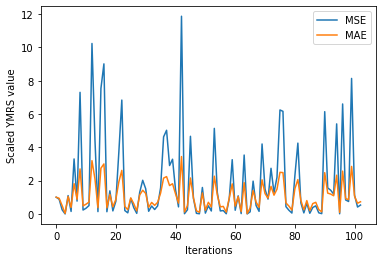

In [22]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(train_loss, label="MSE")
plt.plot(train_mae, label="MAE")
plt.legend()
plt.show()

### Model evaluation - validation set

Subset taken from test data is defined as a validation set.

In [23]:
x_val_visual, x_val_audio = x_test_visual[:30], x_test_audio[:30]
y_val = y_test[:30]

In [24]:
eval_loss = []
eval_mae = []
eval_index = 0

for input_visual, input_audio in zip(x_val_visual, x_val_audio):
    input_visual = reshape_X(input_visual)
    input_audio = reshape_X(input_audio)

    scores = model.evaluate(
        [input_visual,input_audio], 
        y_val[eval_index],
        verbose = 0)
        
    eval_loss.append(scores[0])
    eval_mae.append(scores[1])
    
    eval_index += 1

In [25]:
avg_eval_loss = sum(eval_loss) / len(eval_loss)
avg_eval_mae = sum(eval_mae) / len(eval_mae)
print("Validation loss (avg):", avg_eval_loss, "Validation MAE (avg):", avg_eval_mae)

Validation loss (avg): 0.9592797810704269 Validation MAE (avg): 0.8533621415495872


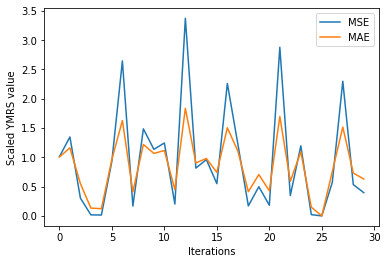

In [26]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(eval_loss, label="MSE")
plt.plot(eval_mae, label="MAE")
plt.legend()
plt.show()

## Prediction

Prediction is made on different subset taken from the test dataset. Then actual and predicted YMRS values are compared.

In [27]:
x_pred_visual, x_pred_audio = x_test_visual[30:], x_test_audio[30:]
y_pred_actual = y_test[30:]

In [28]:
y_prediction = []

pred_scores = []
pred_loss = []
pred_mae = []

pred_index = 0


for test_visual, test_audio in zip(x_pred_visual, x_pred_audio):
    test_visual = np.array(test_visual).reshape((1, test_visual.shape[0], -1))
    test_audio = np.array(test_audio).reshape((1, test_audio.shape[0], -1))
    
    pred_y = y_prediction.append(model.predict([test_visual, test_audio]))
    
    scores = model.evaluate([test_visual, test_audio], y_pred_actual[pred_index], verbose=0)
    pred_scores.append(scores)
    pred_loss.append(scores[0])
    pred_mae.append(scores[1])
    
    pred_index += 1

##### Model evaluation - prediction set

In [29]:
avg_pred_loss = sum(pred_loss) / len(pred_loss)
avg_pred_mae = sum(pred_mae) / len(pred_mae)
print("Prediction loss (avg):", avg_pred_loss, "Prediction MAE (avg):", avg_pred_mae)

Prediction loss (avg): 1.3704527889378368 Prediction MAE (avg): 1.0547998656829198


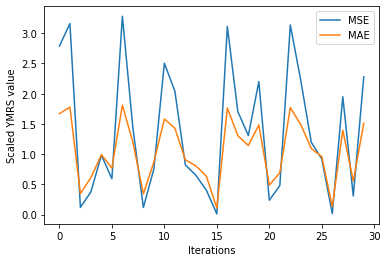

In [30]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(pred_loss, label="MSE")
plt.plot(pred_mae, label="MAE")
plt.legend()
plt.show()

#### Actual vs predicted comparison

In [31]:
y_prediction = np.array(y_prediction).reshape(-1, 1)
y_pred_actual = np.array(y_pred_actual).reshape(-1, 1)

y_prediction = unscale_Y(y_prediction, scaler)
y_pred_actual = unscale_Y(y_pred_actual, scaler)

In [32]:
pred_df = pd.DataFrame(data=np.column_stack((y_pred_actual,y_prediction)),columns=['y_actual','y_pred'])
pred_df['pred_error'] = pred_df['y_actual'] - pred_df['y_pred']
pred_df = pred_df.sort_values(by=['y_actual']).reset_index()
pred_df['y_actual'] = pred_df['y_actual'].apply(np.int64)
pred_df

,index,y_actual,y_pred,pred_error
0,0,0,18.592501,-18.592501
1,1,0,19.796408,-19.796408
2,27,0,15.551173,-15.551173
3,22,0,19.723526,-19.723526
4,16,0,19.644863,-19.644863
5,6,0,20.172493,-20.172493
6,10,1,18.620895,-17.620895
7,29,2,18.811733,-16.811733
8,11,3,18.916502,-15.916502
9,17,3,17.535315,-14.535315


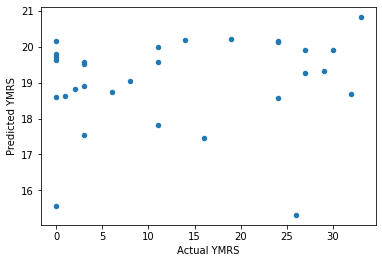

In [33]:
pred_df.plot('y_actual', 'y_pred', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Predicted YMRS")
plt.show()

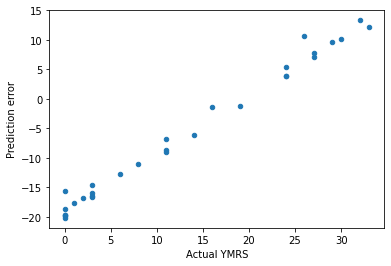

In [34]:
pred_df.plot('y_actual', 'pred_error', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Prediction error")
plt.show()

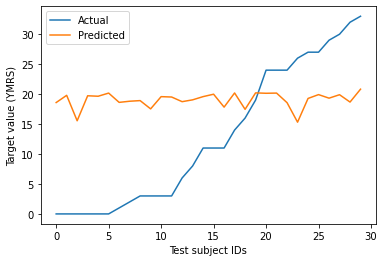

In [35]:
plt.xlabel("Test subject IDs")
plt.ylabel("Target value (YMRS)")
plt.plot(pred_df['y_actual'], label="Actual")
plt.plot(pred_df['y_pred'], label="Predicted")
plt.legend()
plt.show()